## HH Model and Euler function

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pylab as plt
import mpld3
from numba import jit, guvectorize
%matplotlib inline


In [2]:
def step_current(tp):
    ''' Define a custom step current'''
    current = np.empty_like(tp)
    current[0:1000] = 0
    current[1000:2000] = 10
    current[2000:6000] = 0    
    current[6000:13000] = 20 
    current[13000:18000] = 75
    current[18000:28000] = 40
    current[28000:40000] = 10
    
    return current

In [3]:
def euler (f, dt, tfinal, x0): 
    # (f_lorenz, dt=0.001, T=1.0, state0=[-60, 0.5, 0.0, 0.6, 120.0, 20, 0.3] # v, n, m, h ,gna, gk, gl)
    
    """Integrate f from 0 to tfinal using forward Euler
    
    f: system function (dX/dt)
    dt: time step for integration
    tfinal: final time
    x0: initial state
    
    """
    N = int(tfinal / dt) # 40/0.001 -> 40,000 steps
    X = np.zeros((N, x0.size)) # Init a 1000 x 7 array (all state vector values at all time points)
    state = x0.copy() # Start state
    X[0,:] = state # Set the first time point to the start state
    
    for i in range (0, N):
        
        #print "\n\ntime: ", i
        #print "old state :", state
        update = f(state, (i * dt))*dt
        #print "update :", update
        state = state + update
        #print "new state :", state
        X[i,:] = state
    
    return X


In [4]:
def f_HH(state, t):
    """The HH system function. Note augmented state vector includes parameters"""
    
    #print "State shape in f_lorenz: ", state.shape
    deriv = np.zeros_like(state) # state vector = v, n, h, m, gna, gk, gl 
    v, n, h, m, gna, gk, gl = state # unpack state vector
    
    # modify T value here...
    cTime = int(t*(1/dt))
    #print "iapp is: ", iapp[cTime]
    
    # modify V here 
    deriv[0] = ((gna*m*m*m*h*(Ena-v)) + (gk*n*n*n*n*(Ek-v)) + (gl*(El-v)) + iapp[cTime]) / C  
    
    # modify n here
    taun = tn0 + tn1 * (1-math.pow(math.tanh((v - vnt)/dvnt),2))
    nInf = (1+math.tanh((v-vn)/dvn))/2
    deriv[1] = (nInf - n)/taun
    
    #modify h here
    tauh = th0 + th1 * (1-math.pow(math.tanh((v - vht)/dvht),2))
    hInf = (1+math.tanh((v-vh)/dvh))/2
    deriv[2] = (hInf - h)/tauh
    
    #modify m here
    taum = tm0 + tm1 * (1-math.pow(math.tanh((v - vmt)/dvmt),2))
    mInf = (1+math.tanh((v-vm)/dvm))/2
    deriv[3] = (mInf - m)/taum
    
    deriv[4] = 0
    deriv[5] = 0
    deriv[6] = 0
    
    #print "derivs: ", deriv
    return deriv 


In [5]:
# PARTICLE FILTER AND HH MODEL SETTINGS AND PARAMETERS
state0 = np.array([-60, 0.5, 0.0, 0.6, 120.0, 20.0, 0.3]) # v, n, m, h ,gna, gk, gl 
dt = 0.001
T = 40.0

global C, Ena, Ek, El, dvm, tm0, tm1, vm, vmt,dvmt, vh, dvh, th0, th1, vht, dvht, vn, dvn, tn0, tn1, vnt, dvnt, iappall, iapp, gk, gl, gna
global gna, gk, gl

C=1.0 # uF/cm^2
Ena=50.0 # mV        # Na+ nernst potential
Ek=-77.0 # mV        # K+ nernst potential 
El=-54.4 # mV        # leak nernst potential
dvm=15.0 # mV 
tm0=0.1 # ms 
tm1=0.4 # ms
vm=-40.0 # mV
vmt=-40.0 # mV
dvmt=15.0 # mV
vh=-60.0 # mV
dvh=-15.0 # mV
th0=1.0 # ms
th1=7.0 # ms
vht=-60.0 # mV
dvht=-15.0 # mV
vn=-55.0 # mV
dvn=30.0 # mV
tn0=1.0 # ms
tn1=5.0 # ms
vnt=-55.0 # mV
dvnt=30.0 # mV

gna=120.0 
gk=20.0
gl=0.3

tp = np.arange(0.0, T, dt)
iapp = step_current(tp)
#iscale = 100.0
#ipath = '20120406_1_3_15i.dat'
#iapp = np.loadtxt(ipath)[0:40000] * iscale # takes the applied current btwn 10,000-20,000 and scales it 


# generate "data"
data = euler(f_HH, dt, T, state0)

#print "Dimensions:", data.size
#print "FULL DATA: ", data

# also it's best to avoid absolute paths in case someone else wants to run your code
np.save("hh_data.npy", data)



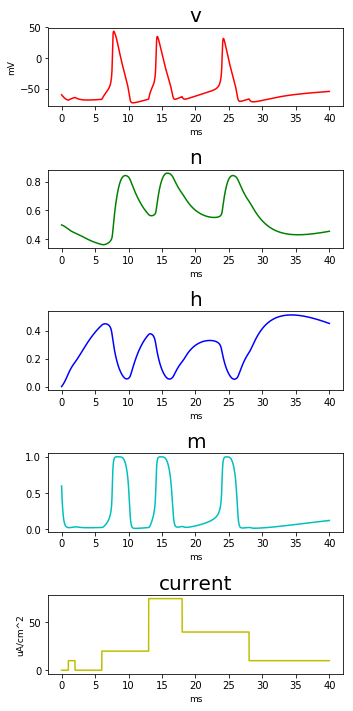

In [6]:
# Display data from default parameter model
#mpld3.enable_notebook()
fig = plt.figure(figsize=(5,10))

plt.tight_layout(pad=30.4, w_pad=30.5, h_pad=30.0)

for i, color, title, ylab in zip(range(5), ('r', 'g', 'b', 'c', 'y'), ("v", "n", "h", "m", "current"), ('mV', '', '', '', "uA/cm^2")):
    ax = plt.subplot(5, 1, i + 1)
    plt.title(title, fontsize=20)
    ax.set_xlabel('ms', fontsize=9)
    ax.set_ylabel(ylab, fontsize=9)
   
    if i == 4: ax.plot(tp, iapp, color) 
    else: ax.plot(tp, data[:, i], color)
        
plt.tight_layout()

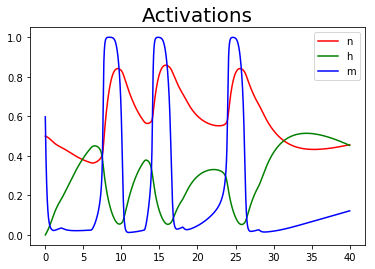

In [7]:
## Combined activations plot
plt.plot(tp, data[:, 1], 'r')
plt.plot(tp, data[:, 2], 'g')
plt.plot(tp, data[:, 3], 'b')
plt.legend('nhm')
plt.title('Activations', fontsize = 20)
plt.show()

## Particle Filter

In [8]:
def ess(weights):
    """Calculate effective sample size of an array of weights"""
    s1 = np.exp(weights).sum()
    s2 = np.exp(2 * weights).sum()  
    ess_D = np.exp(2 * np.log(s1) - np.log(s2))
    return ess_D

#@jit(nopython=True)
def lognormpdf(mu, x, sd):
    """Calculate log of the normal pdf"""
    var = sd**2
    denom = (2 * np.pi * var)**.5
    return ((- (x - mu)**2 / (2 * var))) - (np.log(denom))


In [9]:
#@jit(nopython=True) --> this is some kind of numba operation

def pf_step(p_states, t, dt):
    """Advance the particles one step based on system function
    
    Modifies the values in place.
    
    p_states: particle states (N, D)
    fn: the system function
    t: current time
    dt: step size
    
    """
    N, D = p_states.shape
    #p_states += f_HH(p_states, t) * dt
    for i in range(N):
        p_states[i] += f_HH(p_states[i], t) * dt # why multiply dt here?

#@jit(nopython=True)        
def pf_noise(p_states, sd):
    """Add noise to particles
    
    p_states: particle states (N, D)
    sd: noise standard deviation (D)
    """
    sd[1:4] = 0.005
    
    #print sd
    
    N, D = p_states.shape
    p_states += (np.random.randn(N, D) * sd)
    
    
def pf_weights(p_states, p_weights, data, tol):
    """Update particle weights based on likelihood of data
    
    p_states: particle states (N, D)
    p_weights: particle weights (N,)
    data: observation (L,) [L <= D]
    tol: standard deviation for observation (L,)
    """
    N, D = p_states.shape    
    L = data.size
    
    #print "p_states shape. N: ", N, " D: ", D
    #print "L: ", L
        
    p_weights += lognormpdf(data, p_states[:, :L], tol).sum(axis=1)
    max_weight = max(p_weights) 
    p_weights -= max_weight 

    
def pf_resample(p_states, p_weights):
    """Resample particles based on weights. Returns a copy of p_states."""
    N, D = p_states.shape
    p = np.exp(p_weights)  
    weeded = 0
    '''
    print "\nProbabilities size: ", p.size
    print "State size: ", p_states.shape
    print "Probabilities:", p
    print "State: ", p_states
    '''
    
    for pa in range (p_states.shape[0]):
        if (p_states[pa][0] < -100 or p_states[pa][0] > 100) or (p_states[pa][1] < 0 or p_states[pa][1] > 1) or (p_states[pa][2] < 0 or p_states[pa][2] > 1) or (p_states[pa][3] < 0 or p_states[pa][3] > 1):
            weeded+=1
            p[pa] = 0.0
    
    p /= np.sum(p) # maybe we can optimize this out (dont turn everything into a prob)....
    
    idx = np.random.choice(N, N, replace=True, p=p)
    #print "idx: ", idx
    p_states = p_states[idx, :]
    p_weights[:] = 0
    return p_states, weeded


In [10]:
def pf(data, dt, particles, weights=0, s_sd=0.05, o_sd=1.0, resamp_thresh=0.07):
    """Apply particle filter to data
    
    fn: system function
    data: observations (T, L)
    dt: time step (scalar)
    particles: initial particle states (N, D)
    weights: initial particle weights (scalar or (N,))
    s_sd: standard deviation for system noise (scalar or (D,)
    o_sd: standard deviations for observation noise (scalar or (L,))
    resamp_thresh: threshold effective sample size to resample (scalar)
    """
    ## INITIALIZING PARTICLE FILTER
    N, D = particles.shape
    T, L = data.shape
    
    #print "Particles shape. N: ", N, " D: ", D
    #print "Data shape. T: ", T, " L: ", L
    
    assert L <= D, "Number of observations must be smaller than state vector"
    if np.isscalar(weights):
        weights = np.ones(N, dtype='d') * weights
    else:
        weights = np.asarray(weights, dtype='d')
        assert weights.shape == (N,), "Weights must be scalar or array with nparticles elements"
    if np.isscalar(s_sd):
        s_sd = np.ones(D, dtype='d') * s_sd
    else:
        s_sd = np.asarray(s_sd, dtype='d')
        assert s_sd.shape == (D,), "s_sd must be scalar or array with nstate elements"
    if np.isscalar(o_sd):
        o_sd = np.ones(L, dtype='d') * o_sd
    else:
        o_sd = np.asarray(o_sd, dtype='d')
        assert o_sd.shape == (L,), "o_sd must be scalar or array with nobs elements"
        

    chain = np.zeros((T, N, D), dtype='d')
    chainprob = np.zeros((T, N), dtype='d')
    resample_count = 0
    weed_count = 0
    
    #with progress_bar(T) as pb:
    for i in range(T):
        pf_step(particles, i * dt, dt)
        pf_noise(particles, s_sd)
        pf_weights(particles, weights, data[i], o_sd)
        curr_ess = ess(weights)
        if curr_ess < (resamp_thresh * N):
            resample_count += 1
            particles, weeded = pf_resample(particles, weights)
            weed_count += weeded
        chain[i, :, :] = particles
        chainprob[i, :] = weights
        #pb.update(i)

    return chain, chainprob, resample_count, weed_count

In [16]:
# DRIVER CELL. SET PARAMETERS AND CALL PARTICLE FILTER

nparticles = 2000
starting_noise = [15.0, 0.25, 0.25, 0.25, 15.0, 15.0, 15.0]
driving_noise = 0.05
tolerance = 1.0
resampthresh=0.07
start_pos = np.asarray([-60, 0.5, 0.5, 0.5, 120.0, 20.0, 0.3]) # v, n, m, h ,gna, gk, gl 
# true HH start positions: np.array([-60, 0.5, 0.0, 0.6, 120.0, 20.0, 0.3]) # v, n, m, h ,gna, gk, gl 

# initialize particles in random ball around guess
pstates = np.random.normal(loc = start_pos, scale=starting_noise, size=(nparticles, start_pos.size))

print "pstates (head): \n", pstates[:10, :]

# assimilate some fraction of the data (CDM: speeds up debugging)
L = 1
T_assim = 27000

posteriors, weights, resample_count, weed_count = pf(data[:T_assim,:L], dt, pstates, s_sd=driving_noise, o_sd=tolerance, resamp_thresh=resampthresh)

pstates (head): 
[[ -4.45534015e+01   6.70074257e-01   1.62828833e-01   4.24723483e-01
    1.29933811e+02   1.33559535e+01   2.72501380e+01]
 [ -9.02603153e+01   2.71802696e-01   6.18077017e-01   1.25277811e-01
    1.13243156e+02   4.70913275e+01  -8.60956824e+00]
 [ -4.41026264e+01   6.74503874e-01   7.13256125e-01   5.06939248e-01
    1.38530868e+02  -1.36781232e+01   7.65499210e-01]
 [ -2.74058168e+01   7.25789139e-01   4.96275223e-01   8.44108005e-01
    1.01408702e+02   1.75030248e+01   1.12246124e+01]
 [ -9.11850848e+01   6.76907604e-01   1.00848266e+00   7.03398895e-01
    1.34198624e+02   1.50190985e+00  -1.54321699e+01]
 [ -7.36891510e+01   5.37332165e-01   1.21847175e+00   8.05586854e-01
    1.05213646e+02   2.12237641e+01  -1.39915396e+01]
 [ -3.90156801e+01   1.66416688e-01   2.26701878e-01   3.89339860e-01
    1.01139721e+02   2.39858246e+01   1.41790004e+01]
 [ -8.20549313e+01   6.54572910e-01   1.48031795e-01  -1.34783181e-01
    9.89520104e+01   3.22194321e+01   1.35064

## Plotted Results

Filename? customNoise5
What am I testing? custom noises with huge starting noise


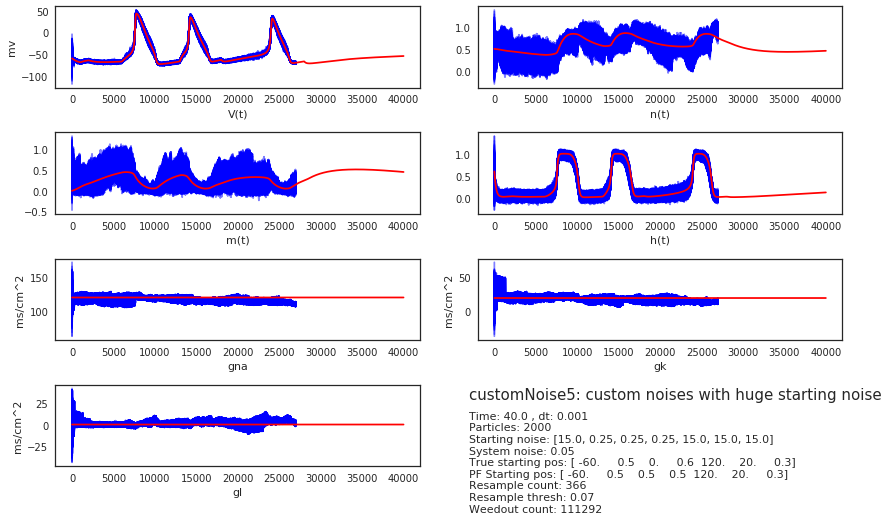

In [17]:
# PLOTTING SINGLE PARTICLE TRACES
filename = raw_input("Filename? ")
description = raw_input("What am I testing? ")

import seaborn as sns
import mpld3
from matplotlib.backends.backend_pdf import PdfPages

sns.set_style('white')
clr_plt = sns.color_palette('cubehelix',4)

fig = plt.figure(figsize=(12, 12))      
plt.tight_layout()
fig.subplots_adjust(top=0.80, bottom = -1.0)

# tre HH start positions: 
true_start_pos = np.array([-60, 0.5, 0.0, 0.6, 120.0, 20.0, 0.3]) # v, n, m, h ,gna, gk, gl 
             
s = 'Time: ' + str(T) + " , dt: " + str(dt) + "\n" + 'Particles: ' + str(nparticles) + "\n" +'Starting noise: ' + str(starting_noise) + "\n" + 'System noise: ' + str(driving_noise) + "\n" + 'True starting pos: ' + str(true_start_pos) + "\n" + 'PF Starting pos: ' + str(start_pos) + "\n" +'Resample count: ' + str(resample_count) + "\n" + 'Resample thresh: ' + str(resampthresh) +"\n" + 'Weedout count: ' + str(weed_count) 
            
fig.text(0.55, 0.40, s, fontsize=11)
fig.text(0.55, 0.53, filename + ": " + description, fontsize=15)

labels = (("V(t)", "mv"), ("n(t)", ""), ("m(t)", ""), ("h(t)", ""), ("gna", "ms/cm^2"), ("gk", "ms/cm^2"), ("gl", "ms/cm^2"))

for i, lbl in enumerate(labels):
    ax = fig.add_subplot(7, 2, i + 1)
    ax.set_xlabel(lbl[0])
    ax.set_ylabel(lbl[1])
    ax.plot(posteriors[:, :2000, i], 'b', alpha = .5)
    ax.plot(data[:, i], 'r')

plt.tight_layout()

#random_name = str(np.random.randn()) + ".pdf"  
curr_file = str(filename) + ".pdf"  
with PdfPages(curr_file) as pdf:
    # As many times as you like, create a figure fig and save it:
    pdf.savefig(fig)

In [ ]:
plt.plot(posteriors[:, :1000, 0], 'b', alpha = .5)
plt.plot(data[:, 0], 'r')